In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

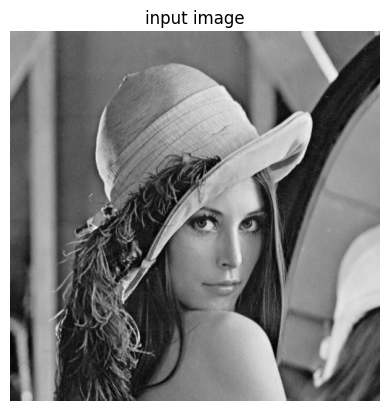

In [2]:
original = cv2.imread("Lena.bmp",cv2.IMREAD_GRAYSCALE)
plt.imshow(original,cmap="gray")
plt.axis("off")
plt.title("input image")
plt.show()

### 随机生成二进制序列

In [3]:
def generate_random_binary_sequence(length):
    """
    生成一个指定长度的二进制序列
    
    params:
    length:(int)序列长度
    
    return:
    binary_sequence:(str)二进制序列
    """
    binary_sequence = ''.join(np.random.choice(['0', '1'], size=length))
    return binary_sequence

sequence_length = 1000000
binary_string = generate_random_binary_sequence(sequence_length)

# Modified Neighbour Mean Interpolation(MNMI)

![step one](step_one.png)

In [4]:
def MNMI(ori_image,string): 
    """
    这个函数是Modified Neighbor Mean Interpolation(MNMI)的实现
    
    params:
    ori_image:(image array)原图
    string:(str)要嵌入的二进制序列
    
    return:
    ori_image:(two-dimension array)隐写图像
    """ 
    ori_image = ori_image.astype(int) # 改变数据类型为int，否则会溢出
    index = 0 # 下一个要嵌入的二进制序列的下标
    capacity = 0
    
    # step 1:插值
    for i in range(ori_image.shape[0]-1):
        for j in range(ori_image.shape[1]-1):
            if i%2==0 and j%2==0 and j<510:
                continue
            elif i%2==0 and j==510:
                continue
            elif j%2==0 and i==510:
                continue
            elif i%2==1 and j==510:
                ori_image[i][j] = round((ori_image[i-1][j]*2+ori_image[i+1][j]*2+
                                   ori_image[i-1][j-2]+ori_image[i+1][j-2])/6)
            elif j%2==1 and i==510:
                ori_image[i][j] = round((ori_image[i][j-1]*2+ori_image[i][j+1]*2+
                                   ori_image[i-2][j-1]+ori_image[i-2][j+1])/6)
            elif i%2==0 and j%2==1 and i<510:
                ori_image[i][j] = round((ori_image[i][j-1]*2+ori_image[i][j+1]*2+
                                   ori_image[i+2][j-1]+ori_image[i+2][j+1])/6)
            elif i%2==1 and j%2==0 and j<510:
                ori_image[i][j] = round((ori_image[i-1][j]*2+ori_image[i+1][j]*2+
                                   ori_image[i-1][j+2]+ori_image[i+1][j+2])/6)
            else:
                ori_image[i][j] = round((ori_image[i-1][j-1]+ori_image[i-1][j+1]+
                                  ori_image[i+1][j-1]+ori_image[i+1][j+1])/4)
                
            
            # step 2:根据像素值替换插入像素的最低位
            # 0~15，192~255替换四位，16~31替换三位，32~191替换两位
            if i%2!=0 or j%2!=0:
                data=''
                bins = bin(ori_image[i][j])[2:]
                while len(bins) < 8:
                    bins = "0"+bins
                
                if 0<=ori_image[i][j]<=15 or 192<=ori_image[i][j]<=255:
                    # 若剩余的二进制序列无法填满这个像素，则return 修改后的图片
                    if index+4>len(string):
                        return ori_image
                    data = bins[:4]+binary_string[index:index+4]
                    index+=4
                    capacity+=4
                elif 16<=ori_image[i][j]<=31:
                    if index+4>len(string):
                        return ori_image
                    data = bins[:5]+binary_string[index:index+3]
                    index+=3
                    capacity+=3
                else:
                    if index+4>len(string):
                        return ori_image
                    data = bins[:6]+binary_string[index:index+2]
                    index+=2
                    capacity+=2
                ori_image[i][j] = int(data,2)
                
    return ori_image,capacity

图片的最大嵌入容量为 425727 bits


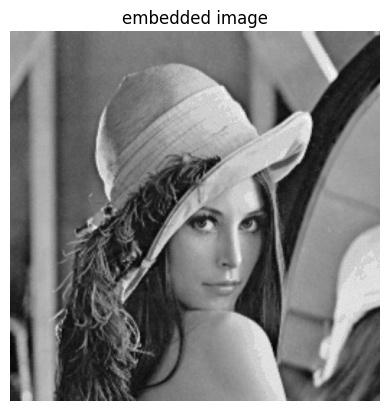

In [5]:
embedded_image,capacity = MNMI(original,binary_string)
print(f"图片的最大嵌入容量为 {capacity} bits")
plt.imshow(embedded_image,cmap="gray")
plt.axis("off")
plt.title("embedded image")
plt.show()

# 提取隐藏数据，恢复原图

In [6]:
def extract(em_image): # params：隐写图像。return：隐写数据
    """
    这个函数用于提取隐写图像中的隐藏数据
    
    params:
    em_image:(two-dimension array)隐写图像
    
    return:
    secret_data:(str)隐藏数据，是一个二进制序列
    """
    new_image = np.zeros_like(em_image)
    secret_data=''
    
    #同样根据step one中的方法计算出插值
    for i in range(em_image.shape[0]-1):
        for j in range(em_image.shape[1]-1):
            if i%2==0 and j%2==0 and j<510:
                continue
            elif i%2==0 and j==510:
                continue
            elif j%2==0 and i==510:
                continue
            elif i%2==1 and j==510:
                new_image[i][j] = round((em_image[i - 1][j] * 2 + em_image[i + 1][j] * 2 +
                                        em_image[i - 1][j - 2] + em_image[i + 1][j - 2]) / 6)
            elif j%2==1 and i==510:
                new_image[i][j] = round((em_image[i][j - 1] * 2 + em_image[i][j + 1] * 2 +
                                        em_image[i - 2][j - 1] + em_image[i - 2][j + 1]) / 6)
            elif i%2==0 and j%2==1 and i<510:
                new_image[i][j] = round((em_image[i][j - 1] * 2 + em_image[i][j + 1] * 2 +
                                        em_image[i + 2][j - 1] + em_image[i + 2][j + 1]) / 6)
            elif i%2==1 and j%2==0 and j<510:
                new_image[i][j] = round((em_image[i - 1][j] * 2 + em_image[i + 1][j] * 2 +
                                        em_image[i - 1][j + 2] + em_image[i + 1][j + 2]) / 6)
            else:
                new_image[i][j] = round((em_image[i - 1][j - 1] + em_image[i - 1][j + 1] +
                                        em_image[i + 1][j - 1] + em_image[i + 1][j + 1]) / 4)
            
            
            # 根据插值的大小判断插入了几位
            bins = bin(em_image[i][j])[2:]
            while len(bins) < 8:
                    bins = "0"+bins
            if 0<=new_image[i][j]<=15 or 192<=new_image[i][j]<=255:
                secret_data+=bins[4:]
            elif 16<=new_image[i][j]<=31:
                secret_data+=bins[5:]
            else:
                secret_data+=bins[6:]
    
    return secret_data

In [7]:
secret_data=extract(embedded_image)

### 比较原数据与提取的数据是否相同

In [8]:
# 比较原数据与提取的数据是否相同
binary_string[:capacity]==secret_data

True

In [9]:
# 提取原图
def get_ori_image(em_image):
    """
    通过下采样的方式提取原图
    
    params:
    em_image:(two-dimension array)隐写图像
    
    return:
    new_image:(two_dimension array)从隐写图像中提取的原图像
    """
    new_image = np.zeros((em_image.shape[0]//2,em_image.shape[1]//2))
    for i in range(em_image.shape[0]):
        for j in range(em_image.shape[1]):
            if i%2==0 and j%2==0:
                new_image[i//2,j//2]=em_image[i][j]
    return new_image

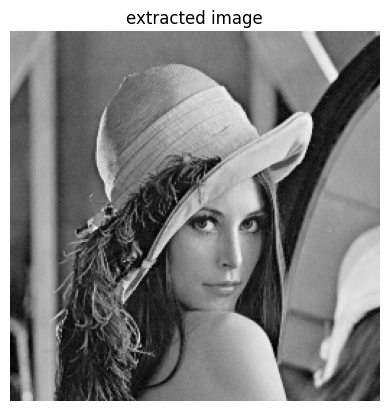

In [10]:
extract_ori_image = get_ori_image(embedded_image)
plt.imshow(extract_ori_image,cmap="gray")
plt.axis("off")
plt.title("extracted image")
plt.show()

# PSNR

![PSNR](PSNR.png)

In [11]:
import math
def PSNR(ori,em,bit_depth):
    """
    计算图像的峰值信噪比PSNR
    
    params:
    ori:(image array or two-dimension array)原图
    em:(two-dimension array)隐写图像
    bit_depth:(int)图像位深
    
    return:
    PSNR:(float)峰值信噪比
    """
    MSE = np.sum(np.square(ori-em))/ori.shape[0]/ori.shape[1]
    PSNR = 10*math.log10((2**bit_depth-1)**2/MSE)
    return PSNR

In [12]:
PSNR(original,embedded_image,8)

31.554195983150827

## 测试嵌入不同比特的情况下PSNR的值 

In [13]:
def compare_PSNR_embedd_bits(ori_path):
    """
    比较在嵌入不同数量比特情况下的PSNR值
    
    params:
    ori_path:(str)原图路径
    
    return:
    lens:(list)嵌入的不同比特值
    PSNRs:(list)在嵌入不同数量比特情况下的PSNR值
    """
    ori_image = cv2.imread(ori_path,cv2.IMREAD_GRAYSCALE)
    string = generate_random_binary_sequence(1000000)
    # 获取图片最大嵌入容量和最大嵌入容量时的隐写图片
    embedded_image, maximum_capacity = MNMI(ori_image,string)
    # 计算最大嵌入容量下的PSNR值
    PSNR_max = PSNR(ori_image,embedded_image,8)
    # 生成多个二进制序列
    test_binary_strings = [generate_random_binary_sequence(i*50000) for i in range(1,maximum_capacity//50000+1)]
    # 每个二进制序列长度
    lens = [len(bins) for bins in test_binary_strings]
    # 生成不同嵌入比特下的隐写图片
    test_embedded_images = [MNMI(ori_image,bins) for bins in test_binary_strings]
    # 计算不同嵌入比特时的PSNR值
    PSNRs = [PSNR(ori_image,embedded,8) for embedded in test_embedded_images]

    lens.append(maximum_capacity)
    PSNRs.append(PSNR_max)
    
    return lens,PSNRs

In [14]:
image_paths=["Airplane.bmp","Lena.bmp","Baboon.bmp"]

In [15]:
results = [compare_PSNR_embedd_bits(path) for path in image_paths]

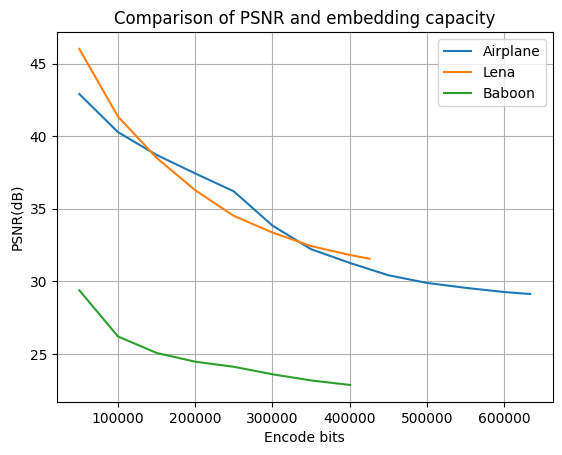

In [16]:
for i in range(len(image_paths)):
    plt.plot(results[i][0],results[i][1],label=image_paths[i][:-4])
plt.xlabel("Encode bits")
plt.ylabel("PSNR(dB)")
plt.title("Comparison of PSNR and embedding capacity")
plt.legend()
plt.grid()
plt.show()